In [91]:
import numpy as np
from scipy.stats import norm, binom
import matplotlib.pyplot as plt
from scipy.integrate import simpson, quad
from math import comb

In the previous blog post, we saw how to estimate a simple parameter *p* that defines the probability of a coin flipping Heads. For the sake of simplicity, we worked with a prior that could only take on 11 values from 0 to 1 in intervals of 0.1. In this blog post, we are going to allow *p* to take on *any* value from 0 to 1 - this entails working with a continuous distribution.

As we'll see, continuous distributions are computationally much more difficult to handle than discreet distributions because they rely on integration instead of summation, something that is much more difficult. In this scenario, we're only trying to solve for a single parameter *p* which modern computers can handle easily. But when dealing with hundreds, if not thousands of parameters as is typically the case in modern Data Science use cases, integrating over their joint distributions quickly becomes impossible (in fact, anything above 3 parameters is already too difficult for most modern PCs to solve! -- TODO: quote). This is why algorithms like Markov Chain Monte Carlo (MCMC) exist.

TODO: maybe add a paragraph on grid searching.

## A Continuous Prior for *p* 
Let's put a normal prior on the probability of flipping heads.

Like the previous blog post, let's assume that the true value for *p* is 0.6 - there is a 60% chance of flipping heads. Again, we'll assume the coin is fair, and so we'll create a prior that is similar to the previous one - centered and symmetric about 0.5. The **Normal Distribution** is an ideal candidate to represent our prior beliefs about the coin's behavior. We give it a standard deviation of 0.1 - if you recall the Normal Distribution's formula, this means we think the value of *p* has a 68% chance of being in [0.4-0.6], a 95% chance of being in [0.3-0.7] a 99% chance of being in [0.2-0.8]. Essentially, the further away a value is from 0.5, the less likely we believe it to be. 

Let's write some code and visualize our prior distribution. We start by defining the parameter space - the set of values that are plausible candidates for *p*, namely all values between 0 and 1. Here, we divide the [0-1] space in 1000 equal sized values and then get each values' associated *density*. Note that the y-axis represents density, not probability! The density represents each values' relative "weight", it is a comparative measure.

But wait! Didn't we say we would have an infinite amount of values? Technically yes, but we can't have an infinite amount of points stored in memory. Isn't this the same as a discrete distribution? No, we're using the normal distribution here and using the PDF formula to calculate each point's associated density. You can redo this example with 100 or 10000 intervals it will be the same.

$f(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right)$

In [94]:
x = np.linspace(0,1,100)
norm_prior = norm.pdf(x, loc = 0.5, scale = 0.1)

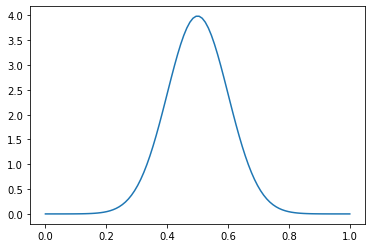

In [95]:
plt.plot(x, norm_prior);

In [97]:
simpson(norm_prior, x =x)

0.9999994303377673

## The Likelihood

Now that we have our prior, let's look at the data. As a reminder, the likelihood function returns a number for each value in our potential parameter space.
As in the previous post, we'll observe some coin tosses and the likelihood function will be the **Binomial Distribution** - we are illustrating the case where we'd want to put a continuous prior on a discreet outcome as the question came up when presenting the material to our colleagues at IBM.

Recall 
$L(p|n, y) = {n \choose y} p^y(1-p)^{n-y} $

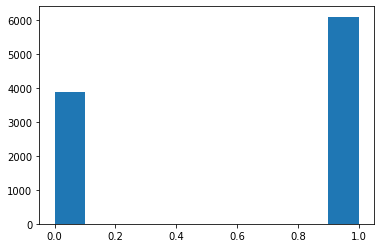

In [28]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
np.random.seed(42) # set seed for reproducibility
# Set the probability of heads = 0.6
p = 0.6
# Flip the Coin 10000 times and observe the results
n_trials = 10000
data = stats.bernoulli.rvs(p, size = n_trials)
# plot results
plt.hist(data);

Let's see what happens when we flip one coin

In [44]:
def likelihood(n, y, theta):
    """
    n: int - number of trials (coin tosses)
    y: int - number of positive outcomes (heads)
    theta: list or array - parameter space for p

    returns a vector of length len(theta) each value being the likelihood for corresponding thetas
    """
    return comb(n,y)*(theta**y) *( (1-theta)**(n-y))

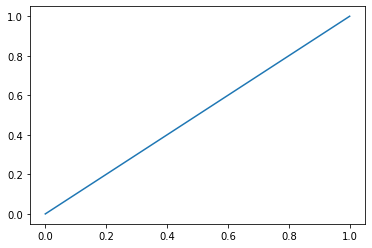

In [45]:
plt.plot(x, likelihood(n = 1, y = sum(data[:1]), theta = x));

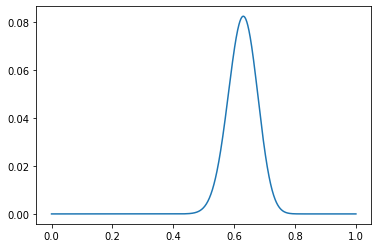

In [46]:
plt.plot(x, likelihood(n = 100, y = sum(data[:100]), theta = x));

In [99]:
simpson(y = likelihood(n = 100, y = sum(data[:100]), theta = x), x = x)

0.009900990099009903

Now that we have our likelihood, we can calculate the joint distribution of $\theta$ and the data

In [47]:
def joint(n, y, theta, loc = 0.5, scale = 0.1):
    """
    n: int - number of trials (coin tosses)
    y: int - number of positive outcomes (heads)
    theta: list or array - parameter space for p

    returns a vector of length len(theta) each value being the joint probability 
    for corresponding thetas and y
    """
    return likelihood(n,y,theta) * (norm.pdf(theta, loc = loc, scale = scale))



In [52]:
sum(data[:1000])

613

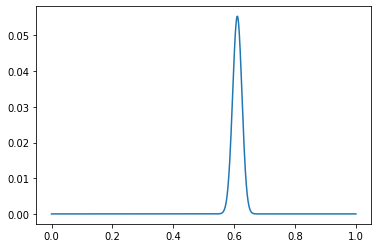

In [53]:
plt.plot(x, joint(1000, sum(data[:1000]), x));

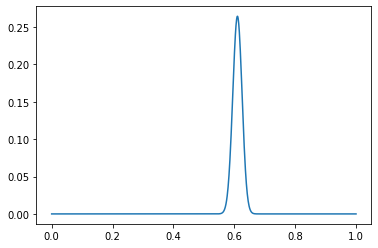

In [55]:
plt.plot(x, joint(1000, 613, x) / simps(joint(1000, 613, x), dx=x[99]-x[0]) );

In [101]:
simpson(joint(1000, sum(data[:1000]), x) / simps(joint(1000, sum(data[:1000]), x), dx=x[1]-x[0]), dx =x[1]-x[0])

0.9999999999999998

## MCMC

In [11]:
mu_current = 0.5

In [12]:
proposal_width = 1
mu_proposal = norm(mu_current, proposal_width).rvs()

mu_proposal

1.9389341083684357

In [84]:
data = np.concatenate((np.repeat(1, 60), np.repeat(0, 40)))

In [14]:
likelihood_current = norm(mu_current, 1).pdf(data).prod()
print(likelihood_current)
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
print(likelihood_proposal)

4.595423685200117e-46
2.832022738604688e-97


In [15]:
mu_prior_mu=0.5 
mu_prior_sd=0.1

In [17]:
# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
print(prior_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
print(prior_proposal)

3.989422804014327
4.364079710267376e-45


In [18]:
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

In [19]:
p_accept = p_proposal / p_current

In [20]:
accept = np.random.rand() < p_accept

In [50]:
samples = 100

In [43]:
mu_proposal = norm(mu_current, proposal_width).rvs()
likelihood_current = binom(p = mu_proposal).pmf(data)


(array([60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.]),
 array([1.84612299e-18, 1.09716968e-17, 2.00972707e-17, 2.92228445e-17,
        3.83484184e-17, 4.74739922e-17, 5.65995661e-17, 6.57251399e-17,
        7.48507137e-17, 8.39762876e-17, 9.31018614e-17]),
 <BarContainer object of 10 artists>)

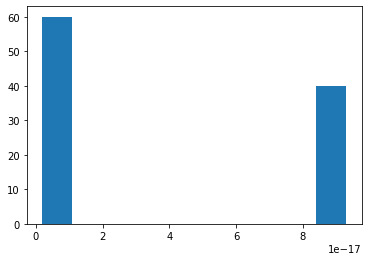

In [45]:
plt.hist(likelihood_current)

In [83]:
sum(data)

40

In [181]:
def make_simple_mcmc(samples = 1000, proposal_width = 1, mu_prior_mu = 0.5, mu_prior_sd = 0.1, SEED_NUM = 0):
    """
    """
    np.random.seed(SEED_NUM)

    p_init=0.5

    mu_current = p_init
    posterior = [mu_current]

    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()
        
        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = binom(n = 100, p = mu_current).pmf(sum(data))
        likelihood_proposal = binom(n = 100, p = mu_proposal).pmf(sum(data))
        

        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
    
    return posterior
    

In [124]:
posterior = make_simple_mcmc(samples = 4000)

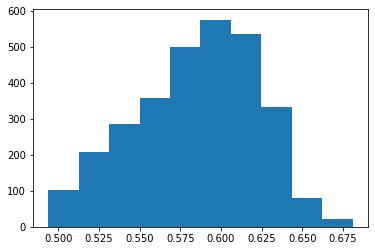

In [125]:
plt.hist(posterior[1000:]);

In [126]:
np.mean(posterior)

0.5850103934894415

In [127]:
np.std(posterior)

0.038218060812291184

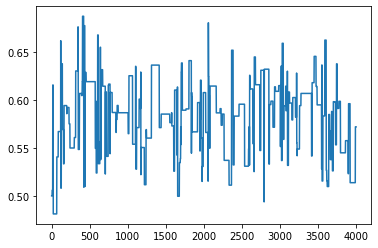

In [128]:
plt.plot(range(len(posterior)), posterior, linestyle ="-")

In [129]:
from multiprocessing import Process

In [131]:
import multiprocessing

multiprocessing.cpu_count()

12

In [182]:
def worker(procnum:int =0, samples= 1000, proposal_width = 1, mu_prior_mu = 0.5, mu_prior_sd = 0.1, SEED_NUM = 0, return_dict = {}):
    return_dict[procnum] = make_simple_mcmc(samples, proposal_width, mu_prior_mu, mu_prior_sd, SEED_NUM)

In [229]:
def multiprocess_mcmc(samples = 1000, proposal_width = 1, mu_prior_mu = 0.5, mu_prior_sd = 0.1):
    import itertools
    if __name__ == "__main__":
        manager = multiprocessing.Manager()
        return_dict = manager.dict()
        procs = 4   # Number of processes to create

        jobs = []
        for i in range(0, procs):
            process = multiprocessing.Process(target=worker, args=(i,4000, 1, 0.5, 0.1, i, return_dict,))
            jobs.append(process)

        # Start the processes 
        for j in jobs:
            j.start()

        # Ensure all of the processes have finished
        for j in jobs:
            j.join()

        print ("Job Complete.")

        return list(itertools.chain.from_iterable(return_dict.values()))

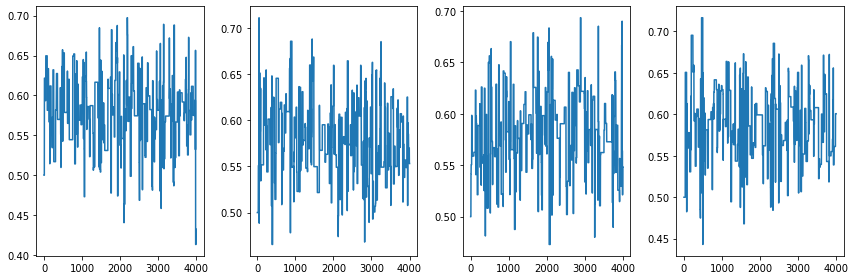

In [196]:
fig, ax = plt.subplots(1,4, figsize = (12,4))

for i in range(len(return_dict)):
    ax[i].plot(return_dict[i])

fig.tight_layout()

In [217]:
# [item for sublist in t for item in sublist]
import itertools

In [218]:
final_dist = list(itertools.chain.from_iterable(return_dict.values()))

In [219]:
len(final_dist)

16004

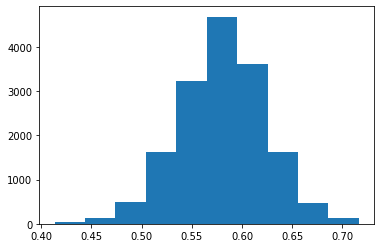

In [224]:
plt.hist(final_dist);

In [227]:
import pandas as pd
pd.Series(final_dist).describe()

count    16004.000000
mean         0.580958
std          0.043165
min          0.413220
25%          0.551350
50%          0.581263
75%          0.608979
max          0.716499
dtype: float64